In [243]:
import time
import glob
import os
import cv2
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn import tree
from sklearn.cluster import DBSCAN

In [2]:
pickle_file = 'data/data.pkl'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as handle:
        datapacket = pickle.load(handle)
        cars = datapacket['cars']
        notcars = datapacket['notcars']
else:
    vehicles = glob.glob('data/vehicles/vehicles/*/*.png')
    nonvehicles = glob.glob('data/non-vehicles/non-vehicles/*/*.png')
    cars = []
    notcars = []
    for f in vehicles:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cars += [img]
    for f in nonvehicles:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        notcars += [img]
    cars = np.array(cars)
    notcars = np.array(notcars)
    data = {'cars' : cars, 'notcars' : notcars}
    with open(pickle_file, "wb") as output_pickle:
        pickle.dump(data, output_pickle)

# Feature Sample

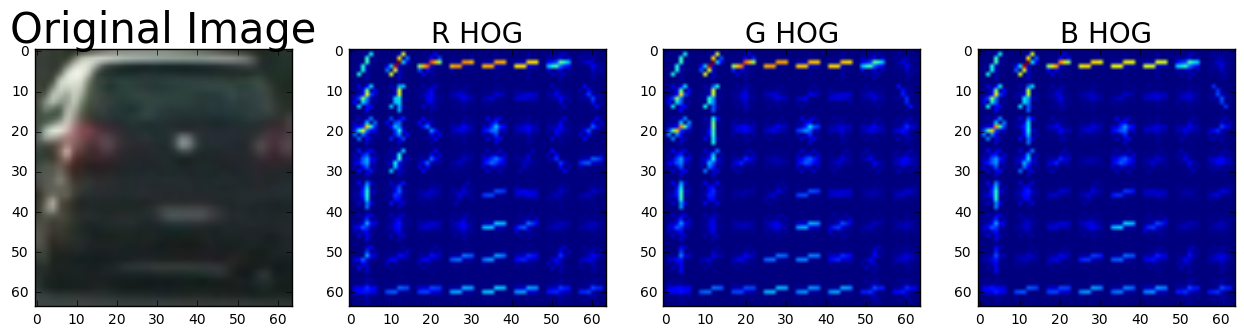

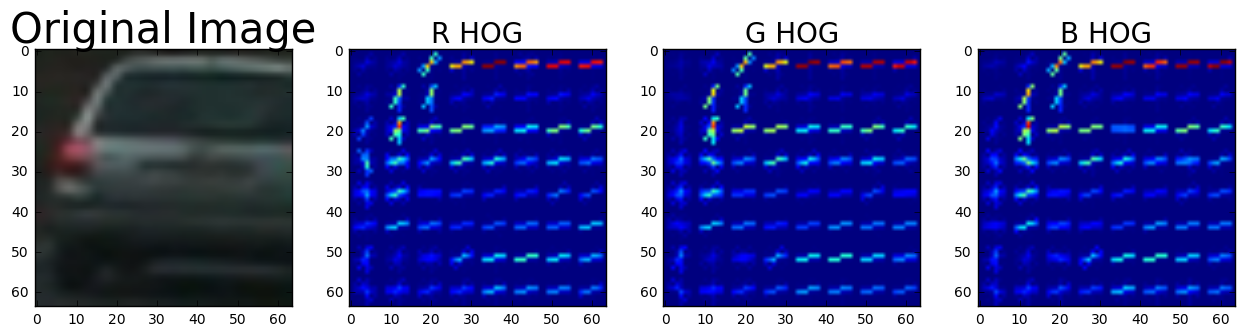

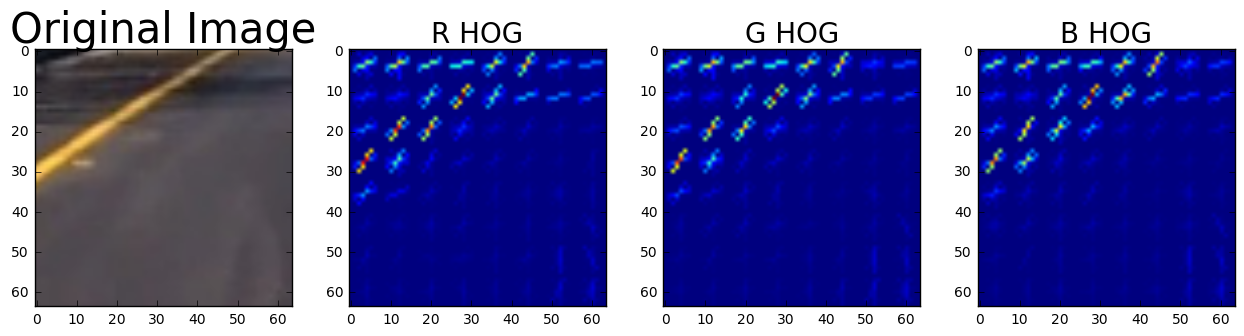

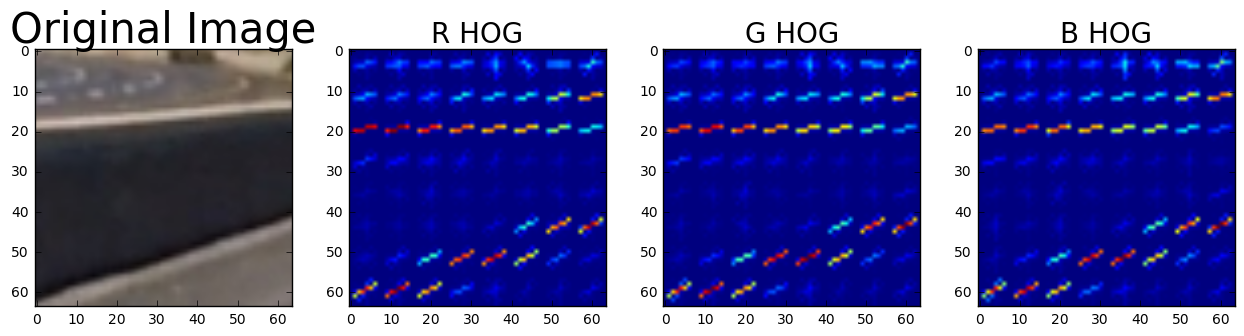

In [249]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

subcars = cars[0:2]
subncars = notcars[0:2]
for img in subcars:
    rhog_feature, rhog_image = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    ghog_feature, ghog_image = get_hog_features(img[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    bhog_feature, bhog_image = get_hog_features(img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)

    # Plot the result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(rhog_image)
    ax2.set_title('R HOG', fontsize=20)
    ax3.imshow(ghog_image)
    ax3.set_title('G HOG', fontsize=20)
    ax4.imshow(bhog_image)
    ax4.set_title('B HOG', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
for img in subncars:
    rhog_feature, rhog_image = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    ghog_feature, ghog_image = get_hog_features(img[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    bhog_feature, bhog_image = get_hog_features(img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(rhog_image)
    ax2.set_title('R HOG', fontsize=20)
    ax3.imshow(ghog_image)
    ax3.set_title('G HOG', fontsize=20)
    ax4.imshow(bhog_image)
    ax4.set_title('B HOG', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

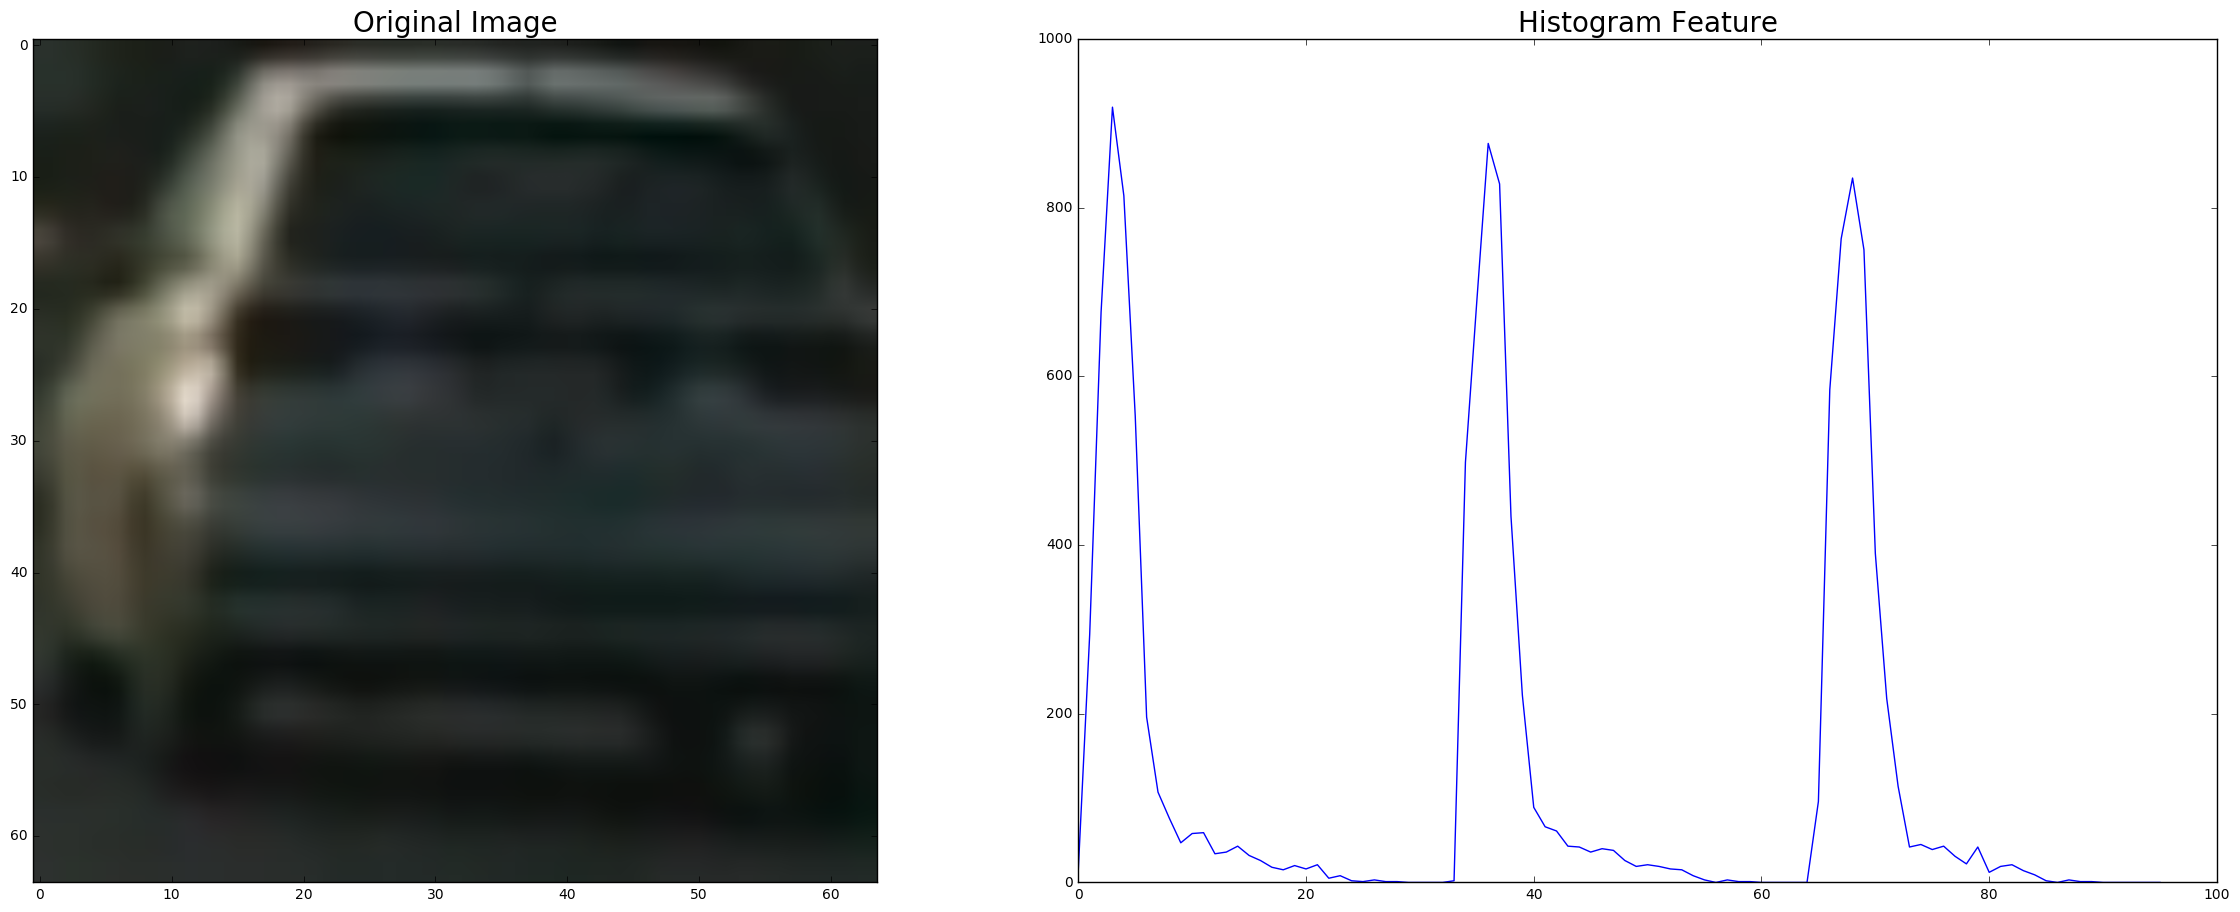

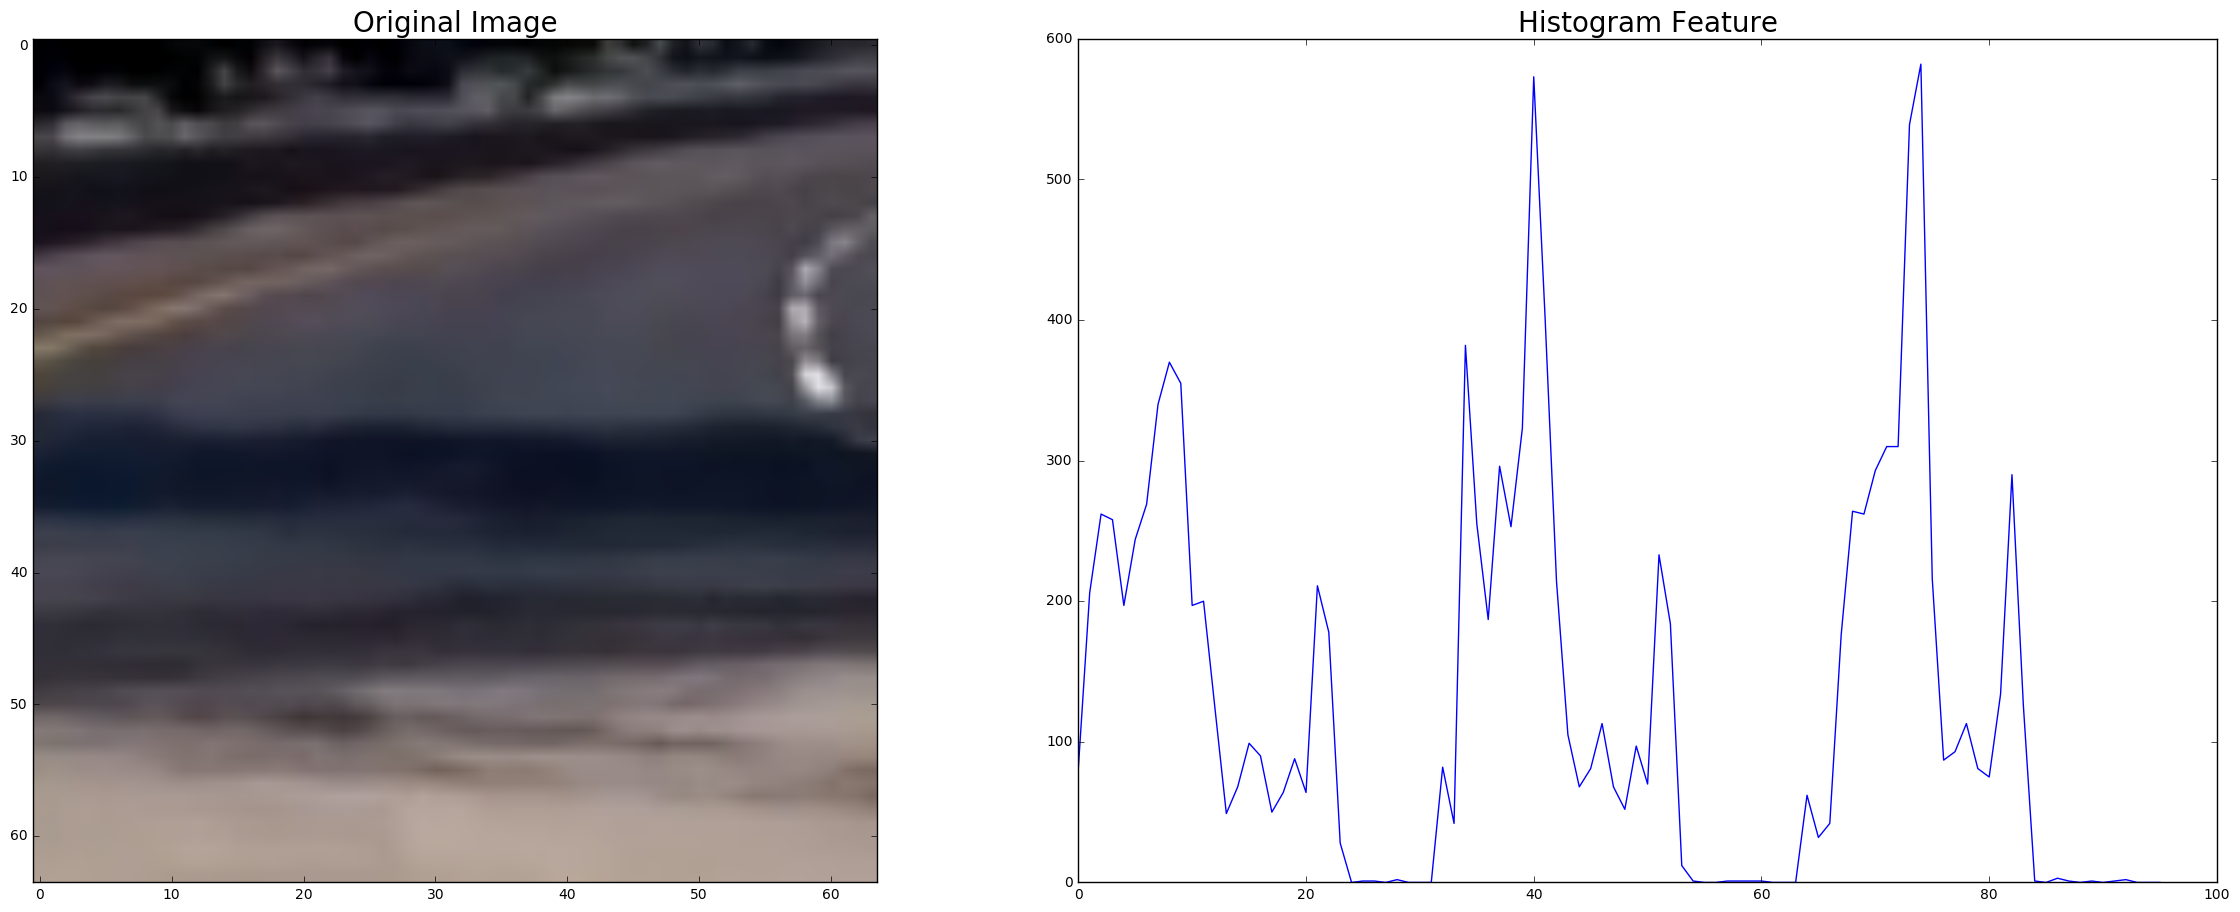

In [250]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

imgs = [cars[5], notcars[5]]
for img in imgs:
    hist_feature = color_hist(img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.plot(hist_feature)
    ax2.set_title('Histogram Feature', fontsize = 20)

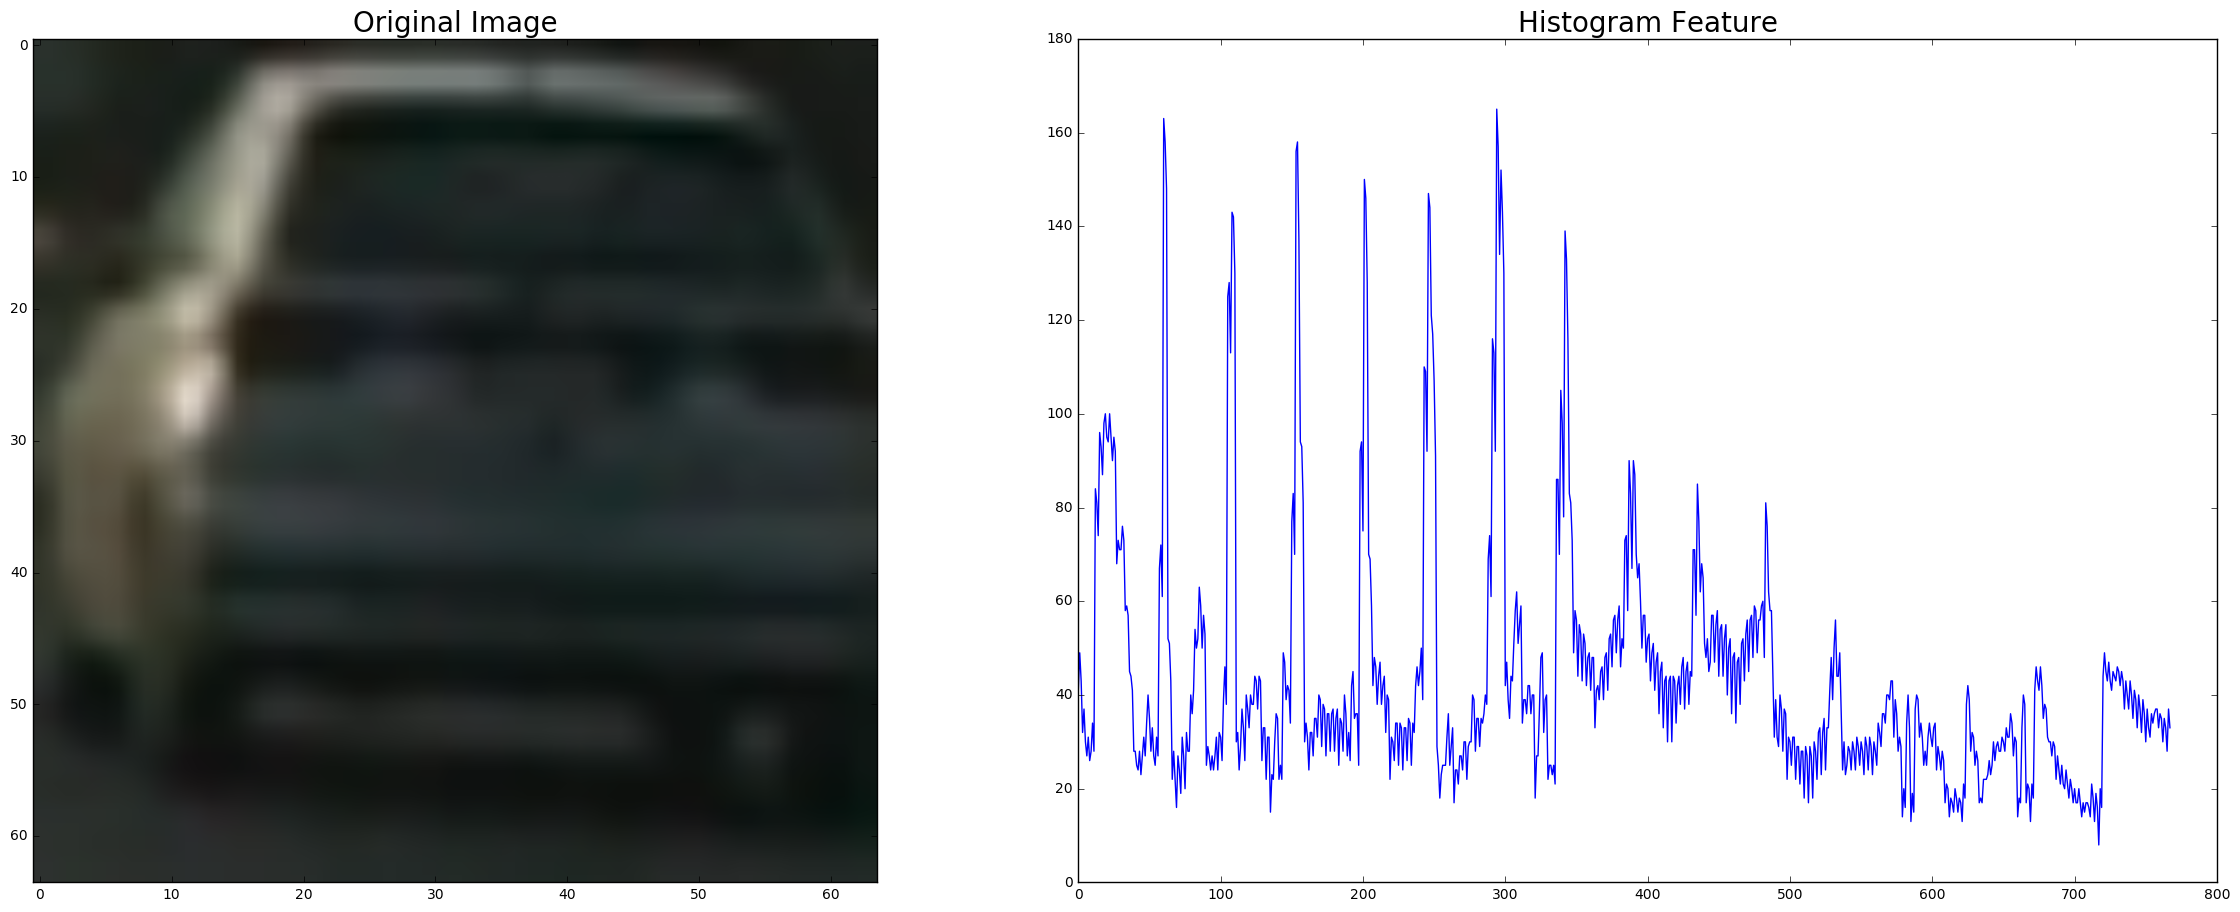

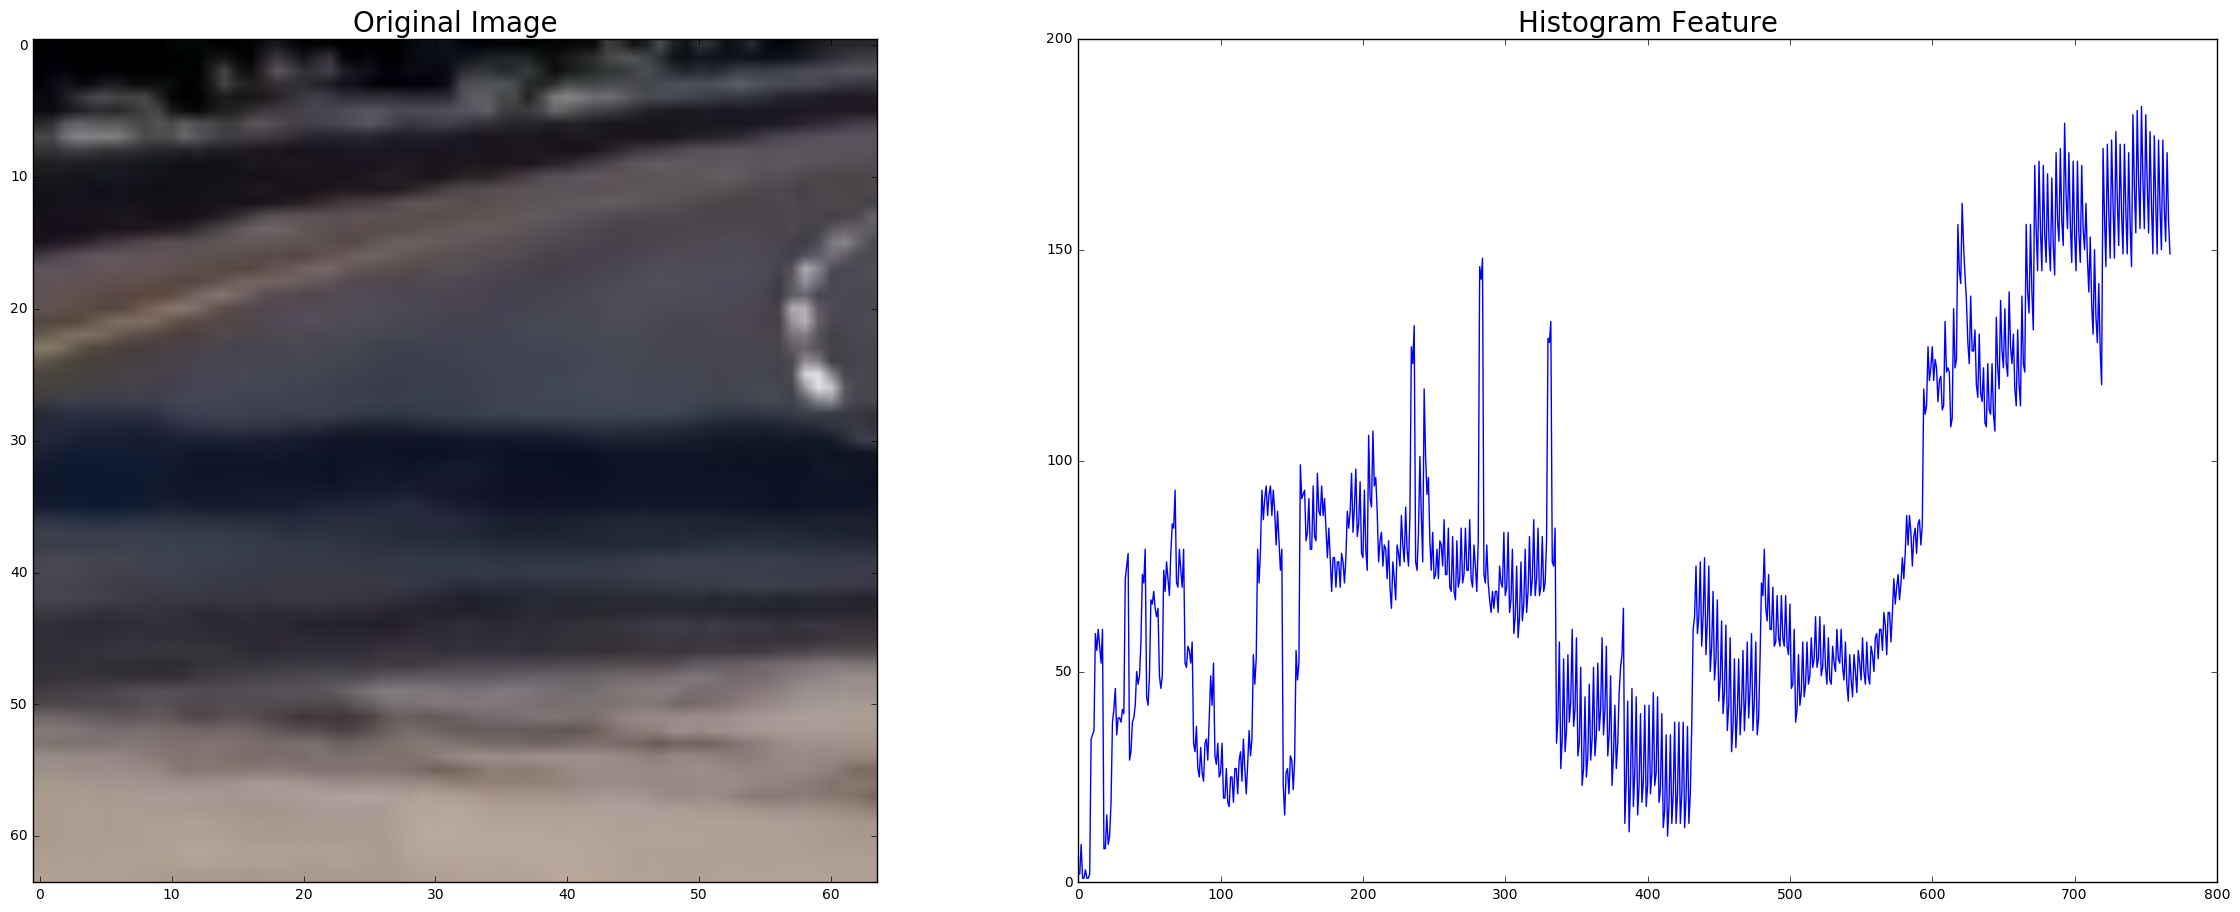

In [251]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

imgs = [cars[5], notcars[5]]
for img in imgs:
    spatial_feature = bin_spatial(img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.plot(spatial_feature)
    ax2.set_title('Histogram Feature', fontsize = 20)

# Single Frame Process

1. Feature Extraction:
    Initial settings for feature extraction was: 
    * HLS colorspace, orient=8, pixel per cell=8, cell per block=2, all three channels are considered for HOG feature
    * size=16 for binned color features
    * nbins = 32 for color histogram features
2. Train classifier:
    An SVC classifier was trained on provided images
3. Predict on single frame: for higher confidence, the overlap ratio for windows are set to 0.8
4. Generate heat map
5. Segment the heat area using DBSCAN

In [3]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, 
                     hog_channel='ALL', hog_feature_vec=True, spa_size=16, n_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
                    
        spatial_features = bin_spatial(feature_image, size=(spa_size, spa_size)) 
        hist_features = color_hist(feature_image, nbins=n_bins)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=hog_feature_vec))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=hog_feature_vec)
        
        temp_features = np.concatenate([spatial_features, hist_features])
        features.append(np.concatenate([temp_features, hog_features]))

    return features

def create_classifier(pos, neg, train_vis=False, Classifier='SVC', cspace='RGB', orient=9, ppcell=8, cpblock=2,
                      hog_channel=0, hog_feature_vec=True, spsize=16, n_bins=32):
    colorspace = cspace
    pix_per_cell = ppcell
    cell_per_block = cpblock
    t_feature_0=time.time()
    car_features = extract_features(pos, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hog_feature_vec=hog_feature_vec,
                            spa_size = spsize, n_bins=n_bins)
    notcar_features = extract_features(neg, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hog_feature_vec=hog_feature_vec,
                            spa_size = spsize, n_bins=n_bins)
    
    t_feature_1 = time.time()
    t_feature = t_feature_1 - t_feature_0
    t_feature = round(t_feature, 2)
    if train_vis:
        print(t_feature, 'Seconds to extract features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    if train_vis:
        print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
    feature_vector_length = len(X_train[0])
    
    if Classifier == 'SVC':
        # Use a linear SVC 
        CLF = LinearSVC(max_iter=20000)
        CLF.fit(X_train, y_train)
    if Classifier == 'DTree':
        # Use Decision Tree
        CLF = tree.DecisionTreeClassifier(max_depth=100, random_state=0)
        CLF.fit(X_train, y_train)
        
    if train_vis:
        print ('classifier trained')
        
    # Check the score of the CLASSIFIER
    accuracy = round(CLF.score(X_test, y_test), 4)
    if train_vis:
        print('Test Accuracy of CLASSIFIER = ', accuracy)
    # Check the prediction time for a single sample
    t_predict_0=time.time()
    n_predict = 10
    if train_vis:
        print('My predicts: ', CLF.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t_predict_1 = time.time()
    t_predict = round(t_predict_1-t_predict_0, 6)
    if train_vis:
        print(t_predict, 'Seconds to predict', n_predict,'labels with ', Classifier)
    
    return CLF, X_scaler, t_feature, t_predict, n_predict, accuracy

The final settings for feature extraction are shown below. The parameters are coming from the trained classifier with the highest test accuracy. The classifier trained on 'HLS' turns out to have a better performance compared with other choices of colorspace, espesially with shadow area.

In [216]:
setting = dict()
setting['cps'] = 'HLS'
setting['ori'] = 8
setting['ppc'] = 8
setting['cpb'] = 2
setting['hoc'] = 'ALL'
setting['sps'] = 16
setting['nbs'] =32

In [217]:
sample_size = 8000
subcars = cars[:sample_size]
subnotcars = notcars[:sample_size]
clf, scaler, t_f, t_p, n_p, acc = create_classifier(subcars, subnotcars, 
                                                    train_vis=True, 
                                                    Classifier='SVC', 
                                                    cspace=setting['cps'], 
                                                    orient=setting['ori'], 
                                                    ppcell=setting['ppc'], 
                                                    cpblock=setting['cpb'],
                                                    hog_channel=setting['hoc'], 
                                                    hog_feature_vec=True,
                                                    spsize=setting['sps'],
                                                    n_bins=setting['nbs'])

55.33 Seconds to extract features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
classifier trained
Test Accuracy of CLASSIFIER =  0.9912
My predicts:  [ 1.  1.  0.  0.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  1.  0.  0.  1.  1.]
0.001485 Seconds to predict 10 labels with  SVC


In [218]:
clf_pickle = dict()
clf_pickle['clf'] = clf
clf_pickle['scaler'] = scaler
clf_pickle['setting'] = setting
clfp = 'classifier/hogtest.pkl'
with open(clfp, "wb") as output_pickle:
    pickle.dump(clf_pickle, output_pickle)

In [240]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_vectors(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                   visualise=vis, feature_vector=feature_vec)
    return features

# Define a function to extract features from a list of images
def extract_features_fromw(fullimg, windows, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, 
                           hog_channel='ALL', hog_feature_vec=False,
                           x_start_stop=[None, None], y_start_stop=[400, 650],
                           spa_size = 16, n_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    image = fullimg[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1]]
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
                    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_vectors(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=hog_feature_vec))        
    else:
        hog_features = get_hog_vectors(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=hog_feature_vec)
    
    n_window = 0
    for window in windows:
        window_image = feature_image[window[0][1]-y_start_stop[0]:window[1][1]-y_start_stop[0], 
                                     window[0][0]-x_start_stop[0]:window[1][0]-x_start_stop[0]]
        # window [[xmin, ymin],[xmax,ymax]]
        hogxmin = int((window[0][0]-x_start_stop[0]) / 8)
        hogymin = int((window[0][1]-y_start_stop[0]) / 8)
        hogxmax = int((window[1][0]-x_start_stop[0]) / 8) - 1
        hogymax = int((window[1][1]-y_start_stop[0]) / 8) - 1
        if hogxmax > hog_features[-1].shape[1]:
            hogxmax = hog_features[-1].shape[1]
            hogxmin = hogxmax-7
        if hogymax > hog_features[-1].shape[0]:
            hogymax = hog_features[-1].shape[0]
            hogymin = hogymax-7
       
        window_features=[]
        if hog_channel == 'ALL':
            for channel in range(3):
                window_features.append(hog_features[channel][hogymin:hogymax, hogxmin:hogxmax].ravel())
            window_features = np.ravel(window_features) 
            
        else:
            window_features.append(hog_features[hogymin:hogymax, hogxmin:hogxmax].ravel())
        
        spatial_features = bin_spatial(window_image, size=(spa_size, spa_size)) 
        hist_features = color_hist(window_image, nbins=n_bins)
        temp_features = np.concatenate([spatial_features, hist_features])
        features.append(np.concatenate([temp_features, window_features]))
        

    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [241]:
with open('classifier/hogtest.pkl', 'rb') as handle:
    datapacket = pickle.load(handle)
    clf = datapacket['clf']
    scaler = datapacket['scaler']
    cspace = datapacket['setting']['cps']
    orient = datapacket['setting']['ori']
    ppcell = datapacket['setting']['ppc']
    cpblck = datapacket['setting']['cpb']
    hogchl = datapacket['setting']['hoc']
    spsize = datapacket['setting']['sps']
    n_bins = datapacket['setting']['nbs']

The range for sliding window is set to [0, 1280] on x and [400, 640] on y, which covers the on-road area. For frame process, a threshold is appllied on heat map to prevent false positives. Foe video process (see the bottom of the page), small bounding boxes from heat map are ignored to prevent false positives. The 'age' setting in the tracker class also helps increasing the accuracy. 

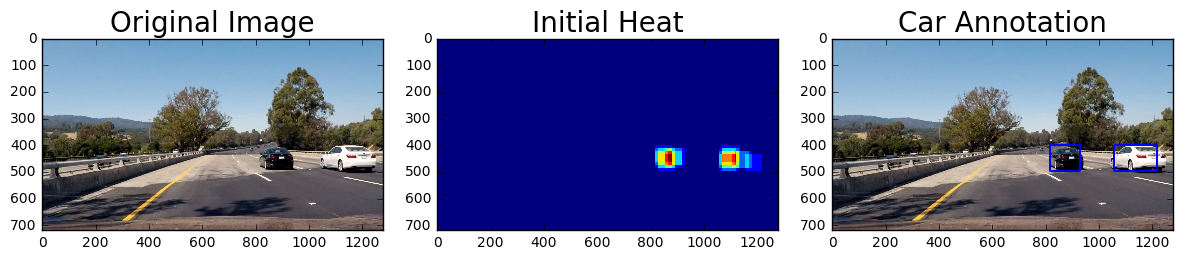

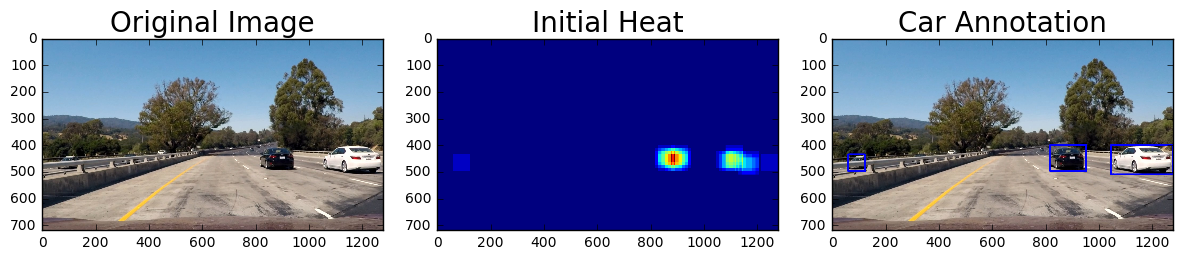

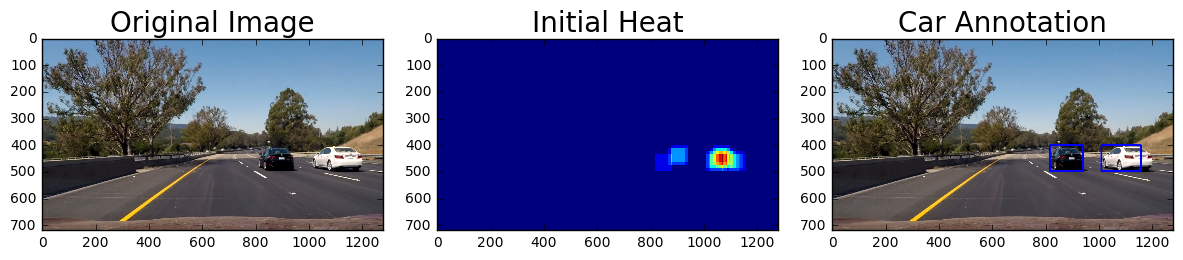

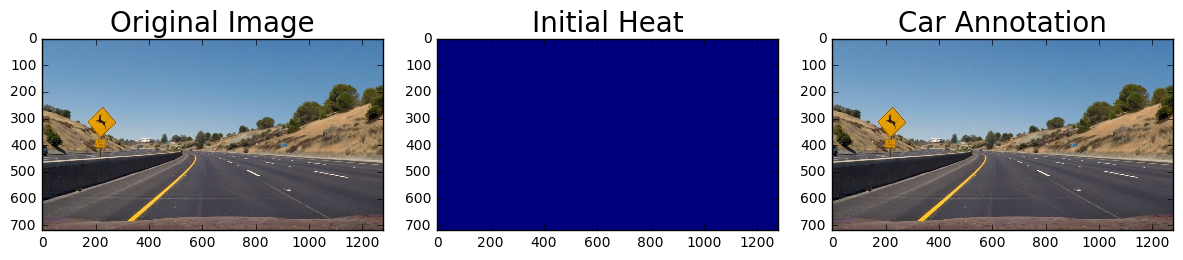

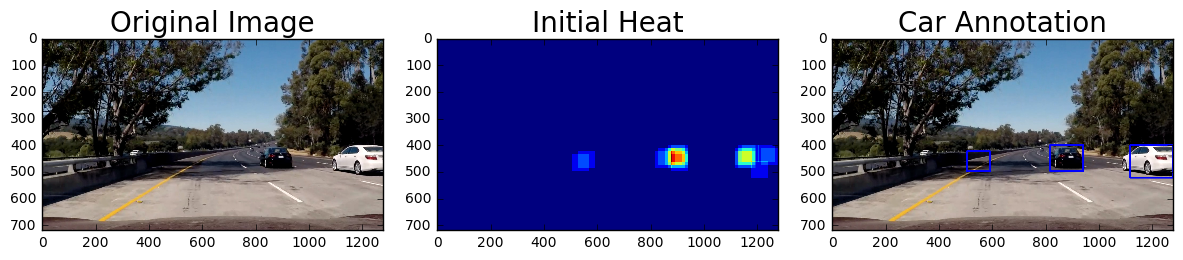

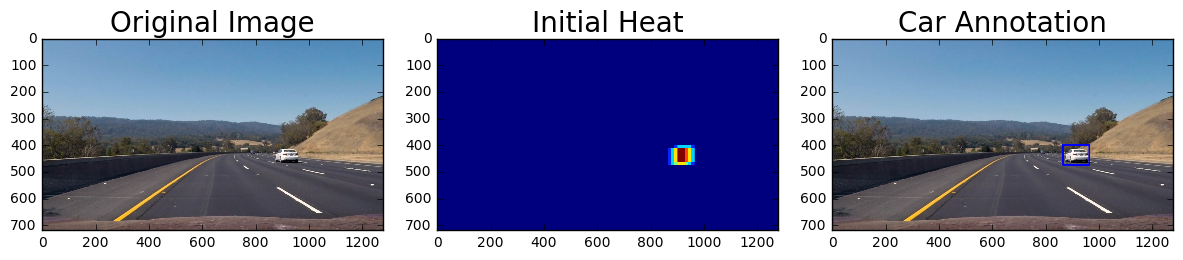

In [248]:
test_images = glob.glob('test_images/*.jpg')
for f in test_images:
    test_image = cv2.imread(f)
    test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    windows = slide_window(test_image, x_start_stop=[0, 1280], y_start_stop=[400, 640],
                           xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    features = extract_features_fromw(test_image, windows,
                                      cspace=cspace, 
                                      orient=orient, 
                                      pix_per_cell=ppcell, 
                                      cell_per_block=cpblck, 
                                      hog_channel=hogchl, 
                                      hog_feature_vec=False,
                                      x_start_stop=[0, 1280], 
                                      y_start_stop=[400, 640],
                                      spa_size = spsize, 
                                      n_bins=n_bins)
    X = scaler.transform(features)
    prediction = clf.predict(X)
    hot_windows = []
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    for i in range(len(windows)):
        if prediction[i] == 1:
            hot_windows.append(windows[i])
    heat = add_heat(heat, hot_windows)   
    heat = apply_threshold(heat, 0)
    if np.count_nonzero(heat) != 0:
        nzero = np.nonzero(heat)
        x = nzero[1]
        y = nzero[0]
        ob = np.array([x,y]).T
        db = DBSCAN(eps=10, min_samples=1).fit(ob)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        boxes = []
        for k in range(n_clusters_):
            class_member_mask = (labels == k)
            xy = ob[class_member_mask & core_samples_mask]
            xmax = np.amax(xy.T[0])
            xmin = np.amin(xy.T[0])
            ymax = np.amax(xy.T[1])
            ymin = np.amin(xy.T[1])
            box = [(xmin, ymin), (xmax, ymax)]
            boxes += [box]
        box_img = draw_boxes(test_image, boxes)
    else:
        box_img = test_image
    
    
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
    f.tight_layout()

    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(heat)
    ax2.set_title('Initial Heat', fontsize = 20)
    ax3.imshow(box_img)
    ax3.set_title('Car Annotation', fontsize = 20)

# Video Process

1. Process on single frame has been described before.
2. Everytime a bounding box is detected, it will be assigned to a tracker object. Future detected boxes will either be merged with existing trackers or being assigned as new trackers.
3. Each exising tracker will be re-evaluated within a small area generated based on the size and location of the current bounding box.
4. Enerytime an exising tracker is updated (merging boxes, passing evaluations, etc.), parameters (coordinates and bounding box width & height) will be passing through a kalman filter.
5. The 'age' setting for each tracker decides whether a bounding box will be drawn on the frame.

### p5.py defines the pipeline for video process.
### The final annotated video is 'annotated_project_video.mp4'

# Summary

1. Selecting subclass of hog features over the full interesing area makes the program faster. But the whole pipeline is still slow.
2. The trained SVC classifier gets confused with shadow.
3. The current tracking pipeline tends to get confused with overlaping objects.
4. A well trained neural network will increase the performance and accucacy significantly.